In [128]:
import yfinance as yf
import datetime as dt
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.metrics import mean_absolute_error as mae

For dataset, we will fetch the stock data of "Power Grid Corporation of India Limited" from the [yahoo finace](https://finance.yahoo.com/) with the help of `yfinace` python module.

In [31]:

start_time = dt.datetime(2020, 1, 1)
end_time = dt.datetime(2025, 2, 28)
stock_id = "POWERGRID.NS"
df = yf.download(stock_id, start_time, end_time)

[*********************100%***********************]  1 of 1 completed


In [32]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,POWERGRID.NS,POWERGRID.NS,POWERGRID.NS,POWERGRID.NS,POWERGRID.NS
Date,,,,,
2020-01-01,80.777489,80.942761,78.608267,78.732226,13620373
2020-01-02,80.612213,81.273309,80.302325,80.798148,5673692
2020-01-03,79.744545,80.488274,79.021467,80.261025,7358268
2020-01-06,79.785851,80.137058,77.678611,79.331353,7355290
2020-01-07,79.207397,80.364316,78.980148,79.806517,14023712


In [33]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,POWERGRID.NS,POWERGRID.NS,POWERGRID.NS,POWERGRID.NS,POWERGRID.NS
Date,,,,,
2025-02-20,265.750000,266.450012,261.299988,262.750000,15312926
2025-02-21,261.899994,265.750000,259.399994,265.299988,10757038
2025-02-24,259.149994,261.799988,257.250000,258.000000,14599185
2025-02-25,255.750000,259.950012,254.899994,258.799988,21287363
2025-02-27,256.250000,257.450012,253.449997,254.000000,13614799


In [34]:
df.reset_index(inplace=True)
df.columns = [col for col, ticker in df.columns.values]
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-01,80.777489,80.942761,78.608267,78.732226,13620373
1,2020-01-02,80.612213,81.273309,80.302325,80.798148,5673692
2,2020-01-03,79.744545,80.488274,79.021467,80.261025,7358268
3,2020-01-06,79.785851,80.137058,77.678611,79.331353,7355290
4,2020-01-07,79.207397,80.364316,78.980148,79.806517,14023712


In [36]:
df.shape

(1280, 6)

In [37]:
df.size

7680

In [38]:
df.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [39]:
df.describe()

,Date,Close,High,Low,Open,Volume
count,1280,1280.000000,1280.000000,1280.000000,1280.000000,1.280000e+03
mean,2022-07-29 20:25:07.500000,163.010668,165.103655,160.941668,163.056150,1.768027e+07
min,2020-01-01 00:00:00,61.752541,65.072568,52.327939,60.638710,8.302140e+05
25%,2021-04-14 12:00:00,101.189602,102.606850,99.579553,101.213812,1.015395e+07
50%,2022-07-26 12:00:00,144.088921,145.447850,142.499360,143.814887,1.397654e+07
75%,2023-11-10 18:00:00,196.183964,198.540044,195.459312,196.326331,2.051815e+07
max,2025-02-27 00:00:00,356.113861,356.893408,348.074624,354.749603,2.260593e+08
std,NaN,81.480026,82.437318,80.433943,81.483574,1.404642e+07


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1280 non-null   datetime64[ns]
 1   Close   1280 non-null   float64       
 2   High    1280 non-null   float64       
 3   Low     1280 non-null   float64       
 4   Open    1280 non-null   float64       
 5   Volume  1280 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 60.1 KB


In [45]:
df["Date"].sort_values().diff().value_counts()# check whether there are missing days in the between periods

Date
1 days    974
3 days    237
2 days     37
4 days     30
5 days      1
Name: count, dtype: int64

In [49]:
df["Date"].dt.day_name().value_counts() # Check by days of week

Date
Thursday     260
Wednesday    256
Tuesday      256
Monday       255
Friday       251
Saturday       2
Name: count, dtype: int64

- **National Stock Exchange of India (NSE), and others follow a Monday to Friday trading schedule. So, 2 inputs of `Saturday` are wrong.**
- **Most likely`Wednesday`,`Tuesday`,`Friday`&`Monday` contain some missing days.**

In [51]:
first_date = df.Date.min()
last_date = df.Date.max()
print(first_date, last_date)

2020-01-01 00:00:00 2025-02-27 00:00:00


In [58]:
# Create date range and convert to DataFrame
date_range = pd.date_range(start=first_date, end=last_date, freq="D").to_frame(index=False, name="Date")

# Merge with the original DataFrame to include all dates
df = df.merge(date_range, how="right", on="Date")
df.isnull().sum()

Date        0
Close     605
High      605
Low       605
Open      605
Volume    605
dtype: int64

In [63]:
# add day as new col
df["day"]=df["Date"].dt.day_name()
df["day"]

0       Wednesday
1        Thursday
2          Friday
3        Saturday
4          Sunday
          ...    
1880       Sunday
1881       Monday
1882      Tuesday
1883    Wednesday
1884     Thursday
Name: day, Length: 1885, dtype: object

In [72]:
df = df[~df["day"].isin(["Saturday", "Sunday"])].drop(columns="day").reset_index(drop=True).copy()

In [73]:
df.isnull().sum()

Date       0
Close     69
High      69
Low       69
Open      69
Volume    69
dtype: int64

# Handel missing values

In [85]:
df.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume           float64
dtype: object

<Axes: >

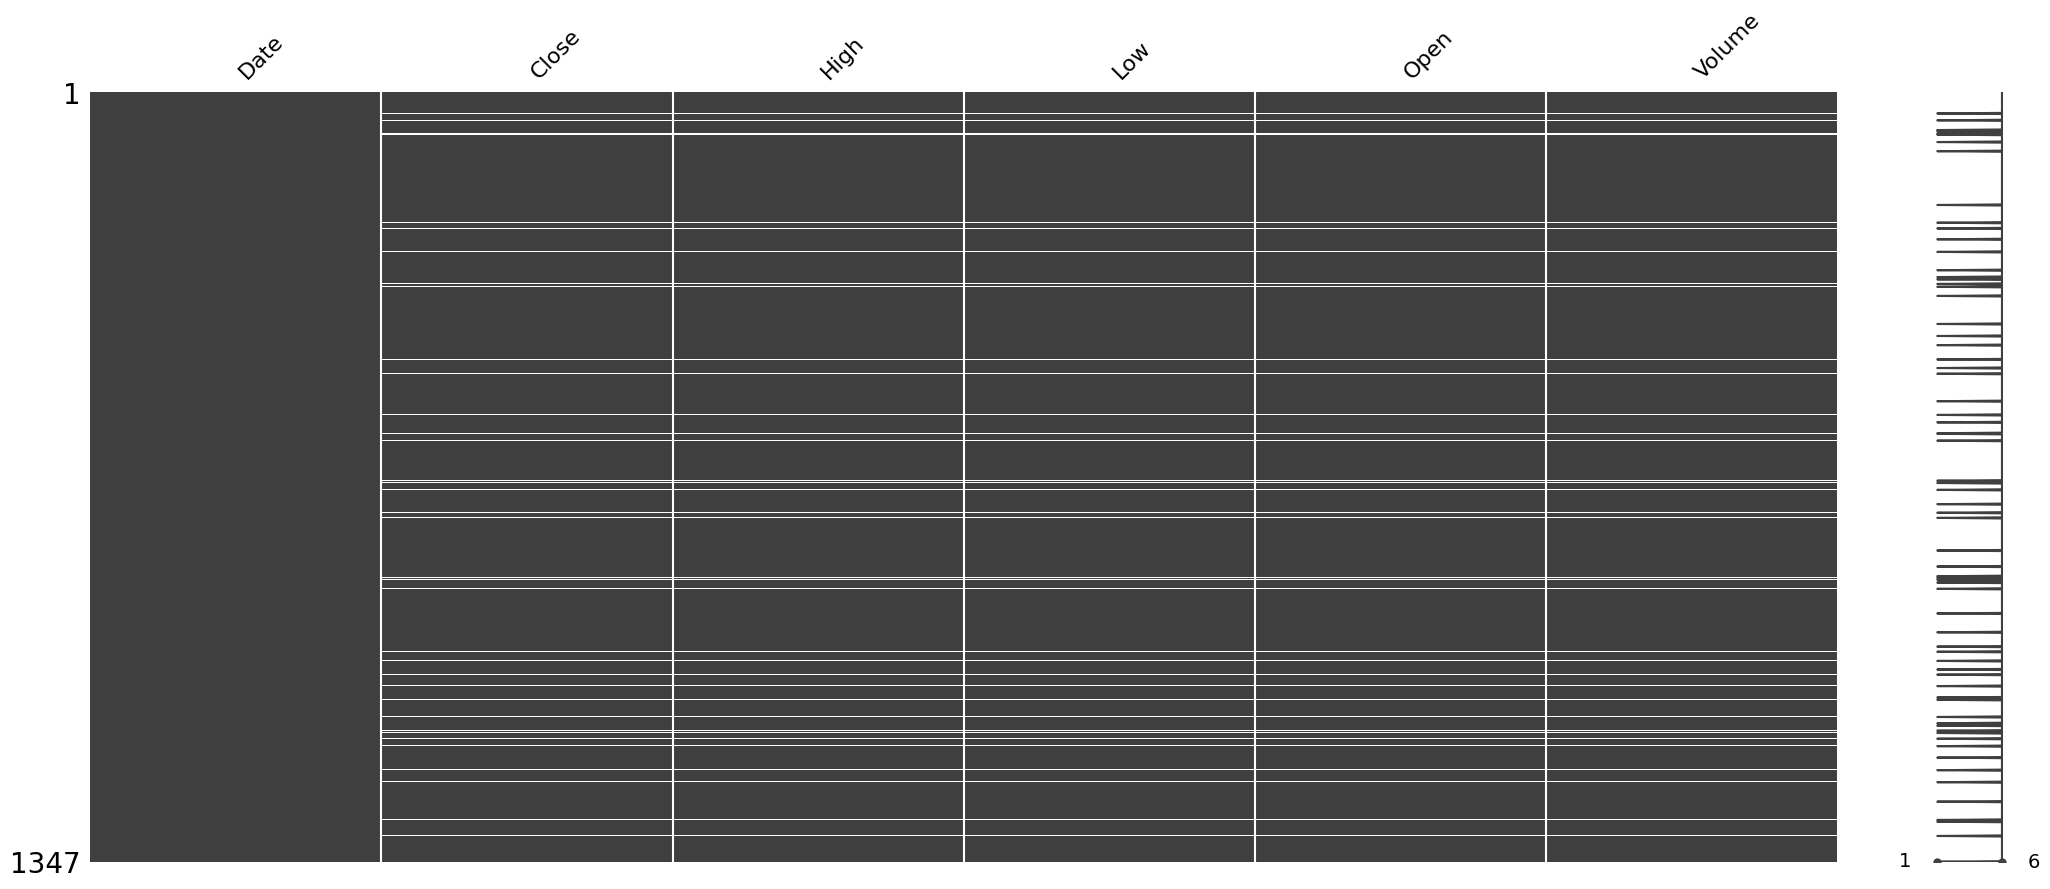

In [98]:
msno.matrix(df.set_index(df.Date))

In [102]:
df[df["Close"].isnull()]

,Date,Close,High,Low,Open,Volume
37,2020-02-21,NaN,NaN,NaN,NaN,NaN
49,2020-03-10,NaN,NaN,NaN,NaN,NaN
66,2020-04-02,NaN,NaN,NaN,NaN,NaN
68,2020-04-06,NaN,NaN,NaN,NaN,NaN
72,2020-04-10,NaN,NaN,NaN,NaN,NaN
74,2020-04-14,NaN,NaN,NaN,NaN,NaN
87,2020-05-01,NaN,NaN,NaN,NaN,NaN
103,2020-05-25,NaN,NaN,NaN,NaN,NaN
197,2020-10-02,NaN,NaN,NaN,NaN,NaN
228,2020-11-16,NaN,NaN,NaN,NaN,NaN


In [164]:
temp = df[df["Date"].between(dt.datetime(2023,6,30), dt.datetime(2023,8,13))].reset_index(drop=True).copy()
temp.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

<Axes: >

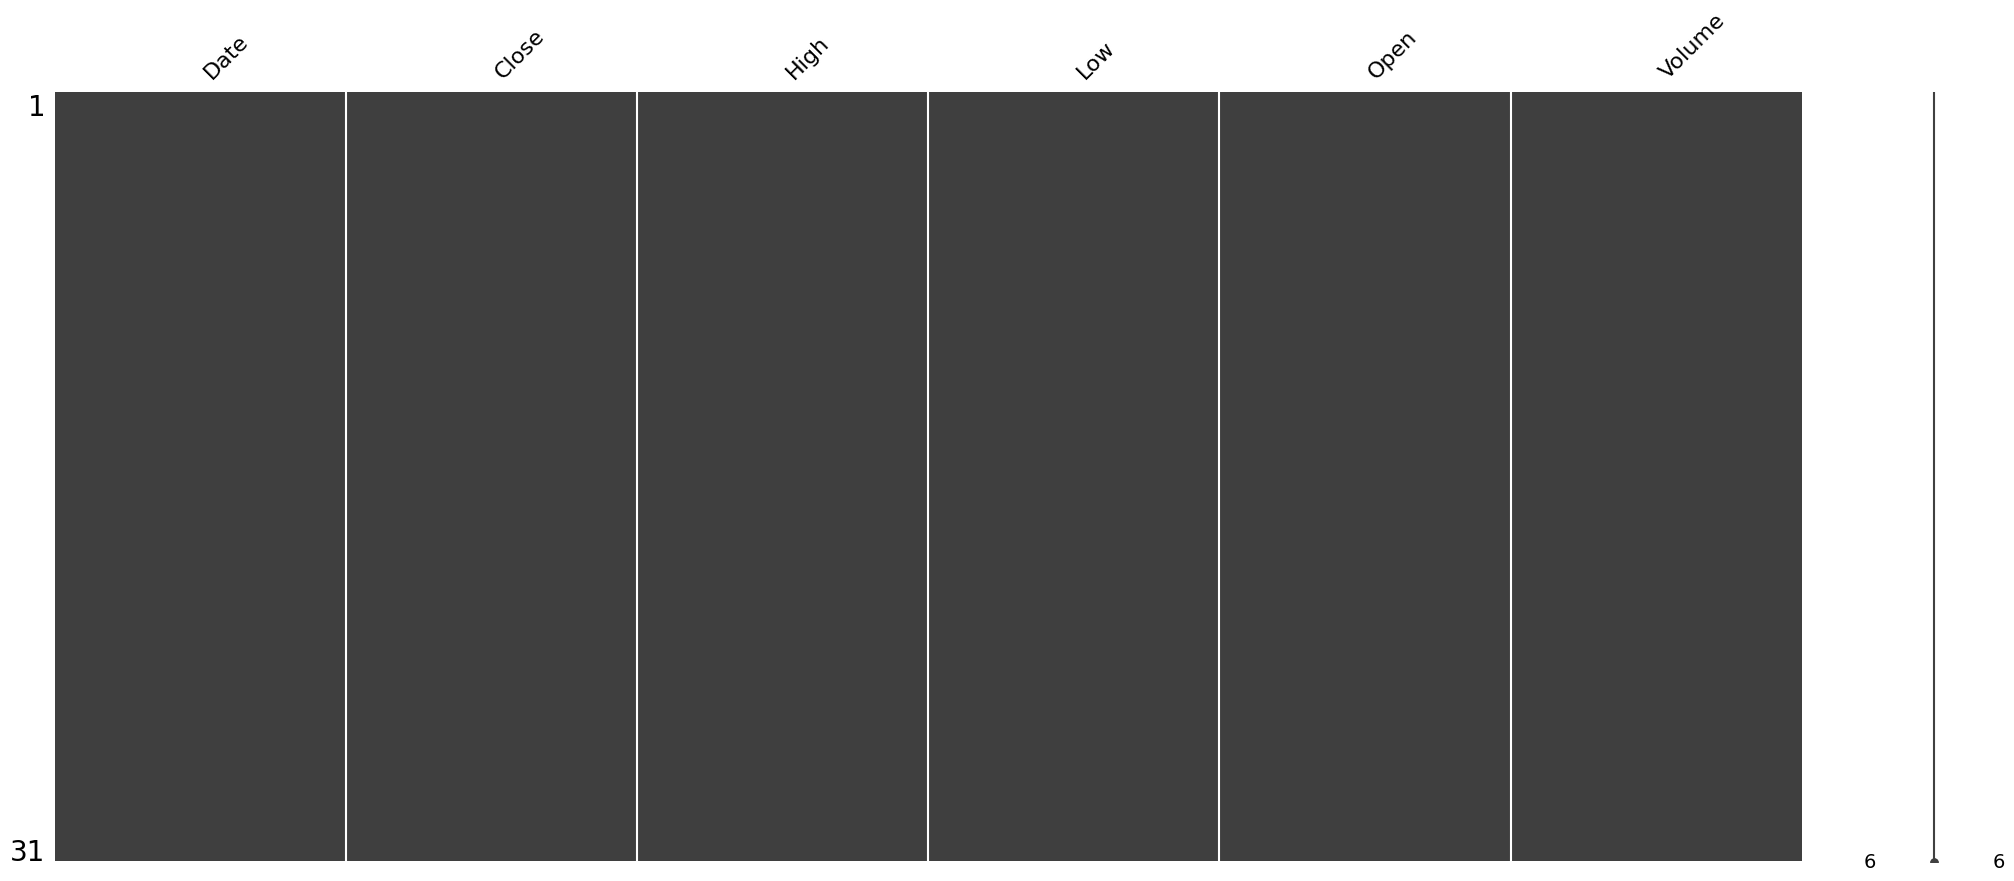

In [165]:
msno.matrix(temp)

In [166]:
missing_values_index = [index for index in range(8, len(temp), 6)]
missing_values_index

[8, 14, 20, 26]

In [167]:

temp["close_with_missing_values"] = temp["Close"]
temp.loc[missing_values_index,"close_with_missing_values"] = np.nan
temp.isnull().sum()

Date                         0
Close                        0
High                         0
Low                          0
Open                         0
Volume                       0
close_with_missing_values    4
dtype: int64

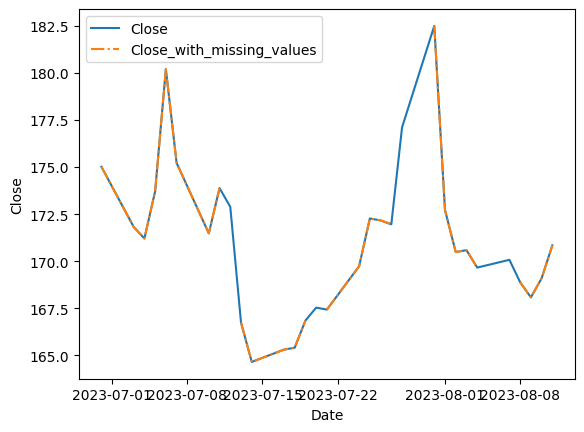

In [168]:
plt.plot(temp["Date"],temp["Close"],"-")
plt.plot(temp["Date"],temp["close_with_missing_values"],"-.")
plt.legend(["Close","Close_with_missing_values"])
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### fill with last day value

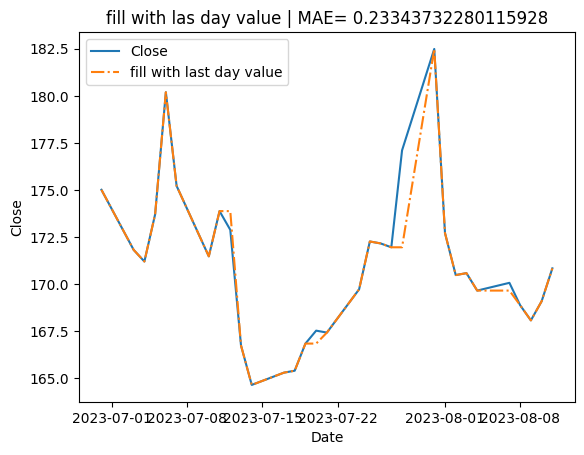

In [169]:
temp["missing_fill_las_day_value"] = temp["close_with_missing_values"]
temp.loc[missing_values_index,"missing_fill_las_day_value"]=temp["Close"].shift(1).iloc[missing_values_index]
plt.title("fill with las day value | MAE= {}".format(mae(temp["Close"],temp["missing_fill_las_day_value"])))
plt.plot(temp["Date"],temp["Close"],"-")
plt.plot(temp["Date"],temp["missing_fill_las_day_value"],"-.")
plt.legend(["Close","fill with last day value"])
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### fill with moving average

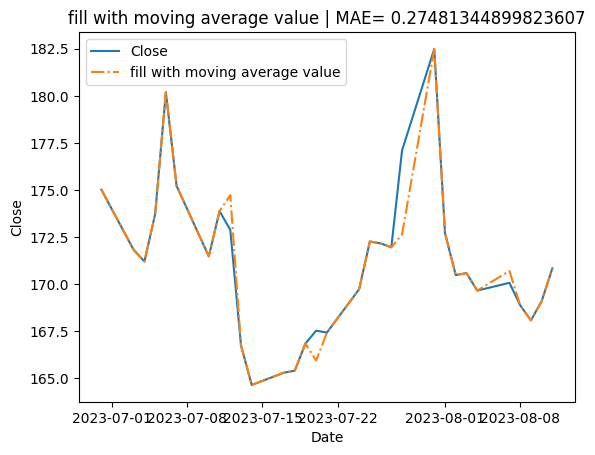

In [170]:
temp["missing_fill_with_moving_average"] = temp["close_with_missing_values"]
temp.loc[missing_values_index,"missing_fill_with_moving_average"]=temp["Close"].rolling(5).mean().iloc[missing_values_index]
plt.title("fill with moving average value | MAE= {}".format(mae(temp["Close"],temp["missing_fill_with_moving_average"])))
plt.plot(temp["Date"],temp["Close"],"-")
plt.plot(temp["Date"],temp["missing_fill_with_moving_average"],"-.")
plt.legend(["Close","fill with moving average value"])
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### fill with last week value

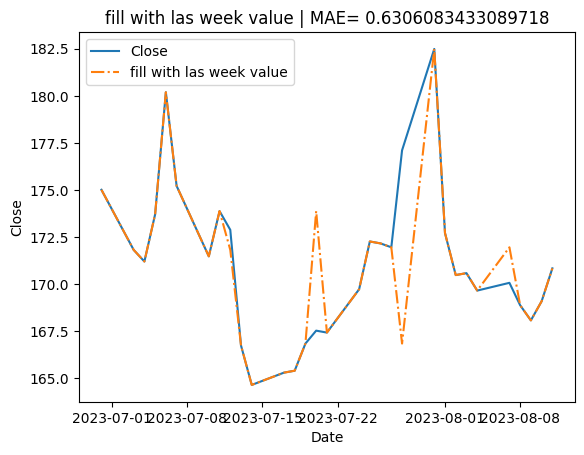

In [171]:
temp["missing_fill_with_last_week"] = temp["close_with_missing_values"]
temp.loc[missing_values_index,"missing_fill_with_last_week"]=temp["Close"].shift(7).iloc[missing_values_index]
plt.title("fill with las week value | MAE= {}".format(mae(temp["Close"],temp["missing_fill_with_last_week"])))
plt.plot(temp["Date"],temp["Close"],"-")
plt.plot(temp["Date"],temp["missing_fill_with_last_week"],"-.")
plt.legend(["Close","fill with las week value"])
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

- **overall filling with last day value is more optimal solution than other due to rapidly change in variance of data over time.**